# Development for cheminformatic reaction mechanism perception and execution

## Development for reactions

In [6]:
from polymerist.smileslib import expanded_SMILES
from polymerist.rdutils.reactions.reactions import AnnotatedReaction
from polymerist.rdutils import rdkdraw

rdkdraw.disable_substruct_highlights()

from rdkit import Chem


def sanitized_mol_with_aromaticity(smiles : str, arom_model : Chem.AromaticityModel=Chem.AROMATICITY_MDL) -> Chem.Mol:
    exp_smiles = expanded_SMILES(smiles, assign_map_nums=False)
    mol = Chem.MolFromSmiles(exp_smiles, sanitize=False)
    Chem.SanitizeMol(mol)
    Chem.Kekulize(mol, clearAromaticFlags=True)
    Chem.SetAromaticity(mol, model=arom_model)
    
    return mol

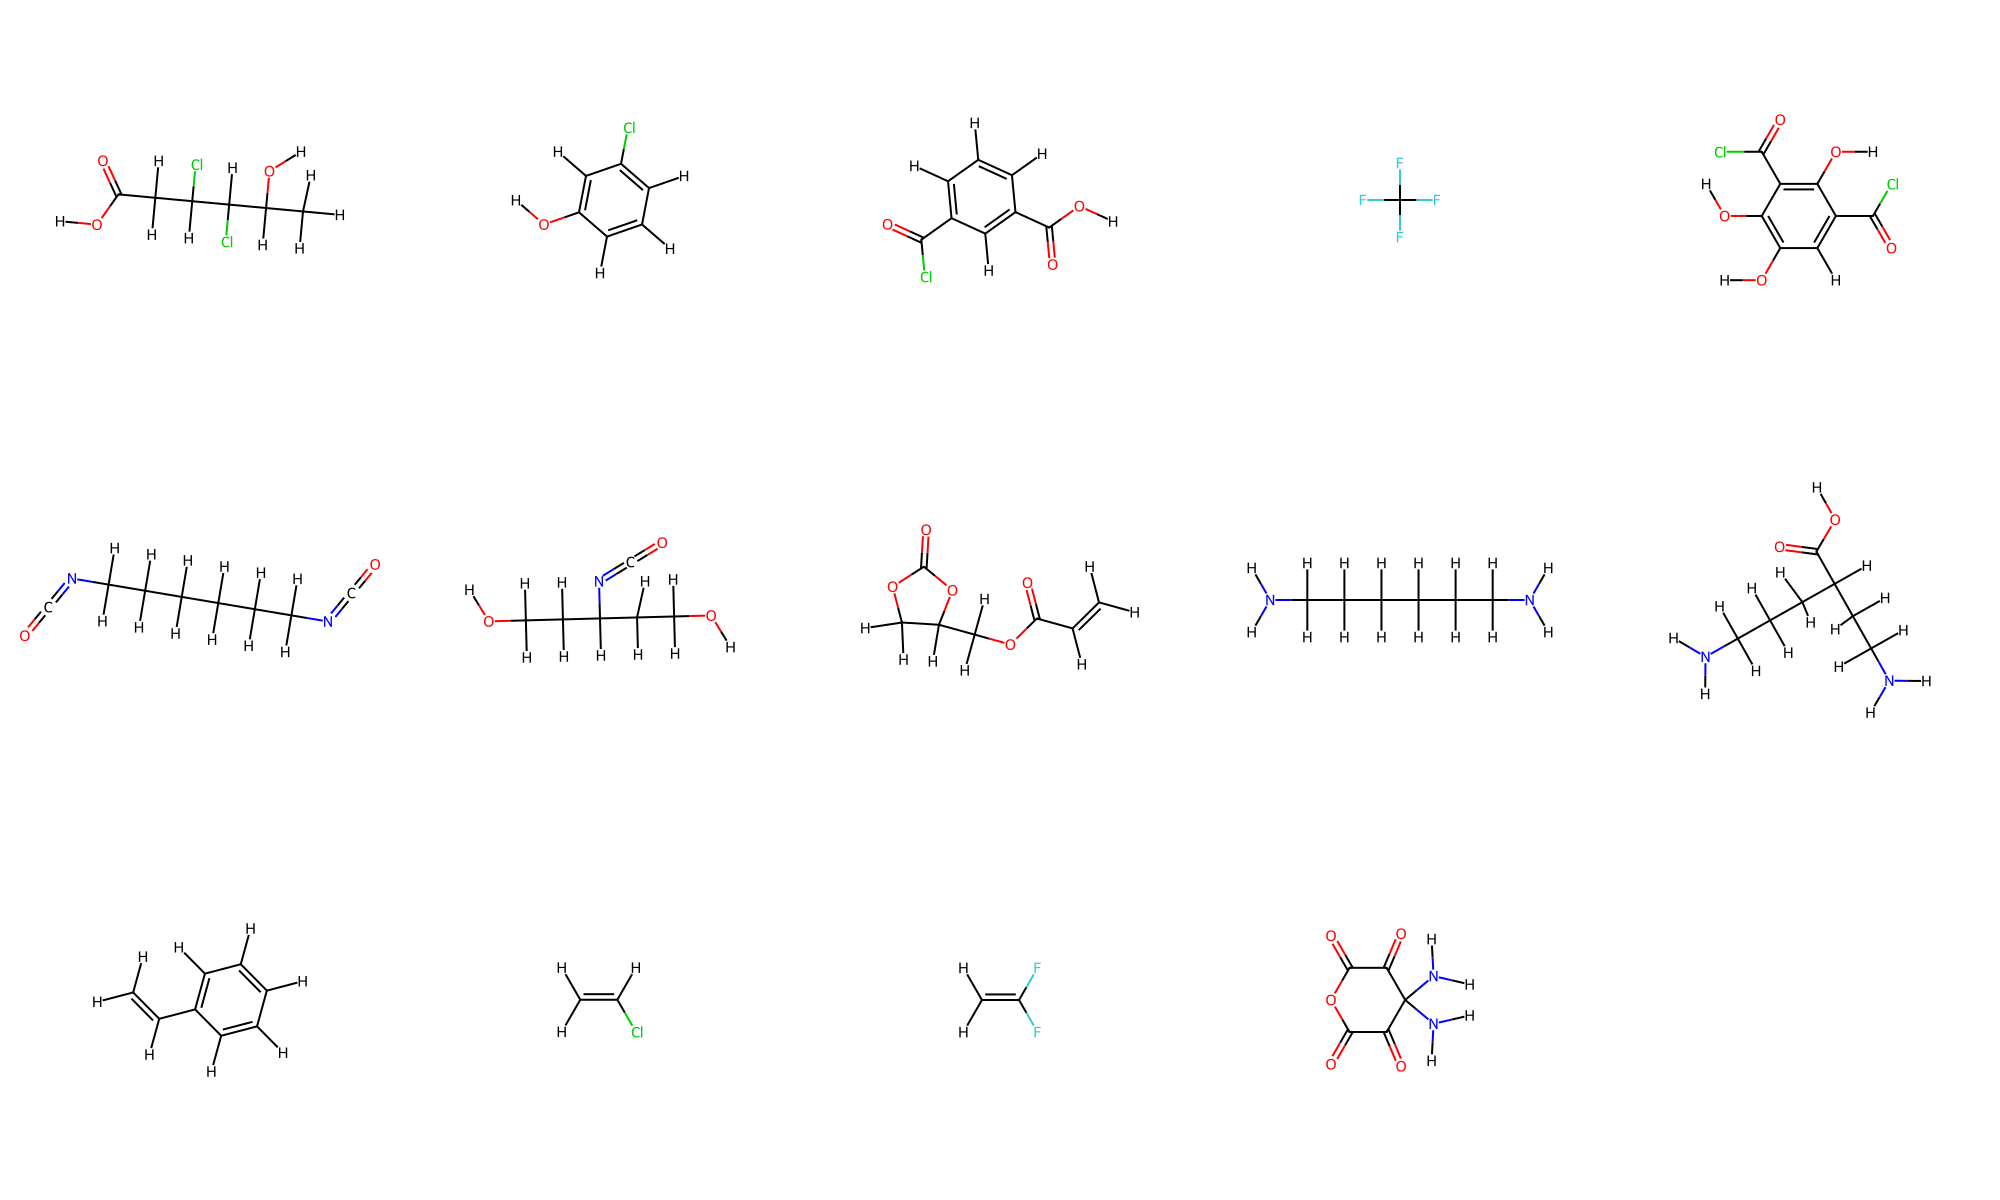

polyamide


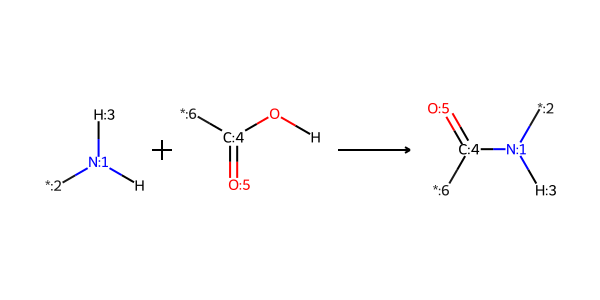

polyester


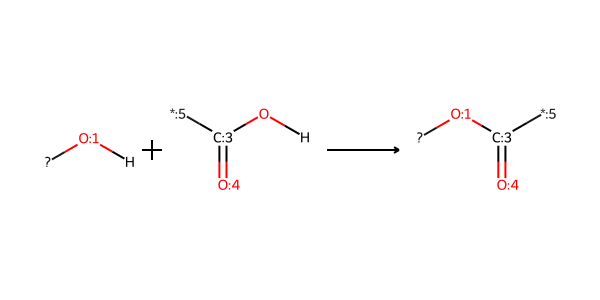

polyvinyl


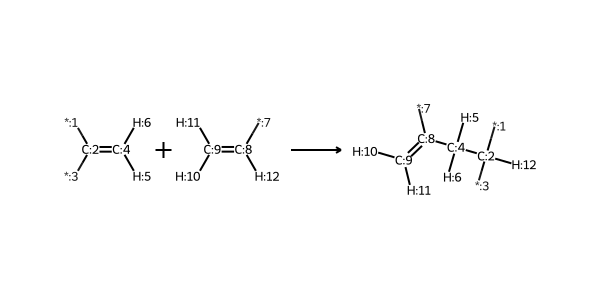

polycarbonate


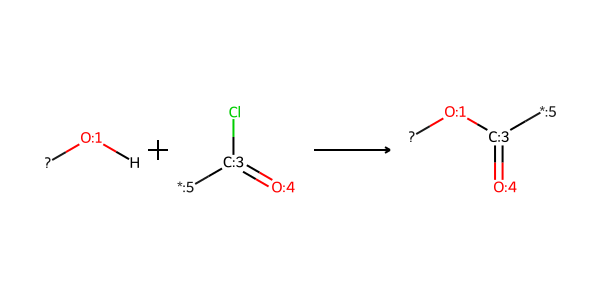

polyurethane_isocyanate


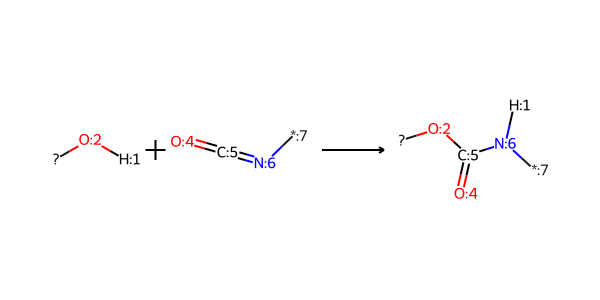

polyurethane_nonisocyanate


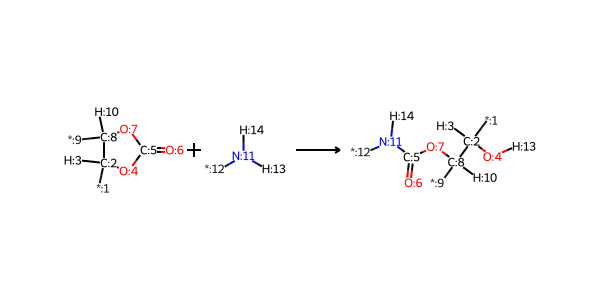

polyimide


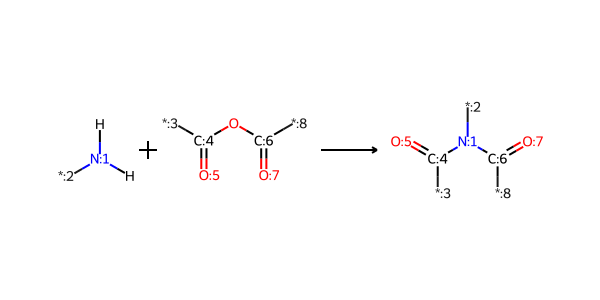

In [21]:
from rdkit.Chem.Draw import MolsToGridImage

# DEFINING REACTANTS
reactant_smiles = [ 
    'CC(O)C(Cl)C(Cl)CC(=O)O',
    'c1ccc(Cl)cc1O',
    'c1ccc(C(=O)Cl)cc1C(=O)O',
    'FC(F)(F)F',
    'c1(O)c(O)c(C(=O)Cl)c(O)c(C(=O)Cl)c1',
    'O=C=N\\CCCCCC/N=C=O',
    'OCCC(N=C=O)CCO',
    'C=CC(=O)OCC1COC(=O)O1',
    'NCCCCCCN',
    'NCCC(C(=O)O)CCCN',
    'C=Cc1ccccc1',
    'C=C(Cl)',
    'FC(F)=C',
    'O1C(=O)C(=O)C(N)(N)C(=O)C(=O)1'
]
reactants = [
    sanitized_mol_with_aromaticity(smiles)
        for smiles in reactant_smiles
]

N = 400
display(MolsToGridImage(reactants, molsPerRow=5, subImgSize=(N, N)))

# DEFINING REACTIONS
RXN_SMARTS : dict[str, str] = {
    'polyamide'     : '[#7:1](-[*:2])(-[#1])-[#1:3].[#8](-[#6:4](=[#8:5])-[*:6])-[#1]>>[#7:1](-[*:2])(-[#1:3])-[#6:4](=[#8:5])-[*:6]',
    'polyester'     : '[#1]-[#8:1]-[!$([#6]=[#8]):2].[#8](-[#6:3](=[#8:4])-[*:5])-[#1]>>[#8:1](-[!$([#6]=[#8]):2])-[#6:3](=[#8:4])-[*:5]',
    'polyvinyl'     : '[*:1]-[#6:2](-[*:3])=[#6:4](-[#1:5])-[#1:6].[*:7]-[#6:8](=[#6:9](-[#1:10])-[#1:11])-[#1:12]>>[*:1]-[#6:2](-[*:3])(-[#6:4](-[#1:5])(-[#1:6])-[#6:8](-[*:7])=[#6:9](-[#1:10])-[#1:11])-[#1:12]',
    'polycarbonate' : '[#1]-[#8:1]-[!$([#6]=[#8]):2].[#17]-[#6:3](=[#8:4])-[*:5]>>[#8:1](-[!$([#6]=[#8]):2])-[#6:3](=[#8:4])-[*:5]',
    'polyurethane_isocyanate': '[#1:1]-[#8:2]-[!$([#6]=[#8]):3].[#8:4]=[#6:5]=[#7:6]-[*:7]>>[#1:1]-[#7:6](-[#6:5](-[#8:2]-[!$([#6]=[#8]):3])=[#8:4])-[*:7]',
    'polyurethane_nonisocyanate': '[*:1]-[#6:2]1(-[#1:3])-[#8:4]-[#6:5](=[#8:6])-[#8:7]-[#6:8]-1(-[*:9])-[#1:10].[#7:11](-[*:12])(-[#1:13])-[#1:14]>>[*:1]-[#6:2](-[#1:3])(-[#8:4]-[#1:13])-[#6:8](-[#8:7]-[#6:5](=[#8:6])-[#7:11](-[*:12])-[#1:14])(-[*:9])-[#1:10]',
    # NOTE: have deliberately excluded compatible reactants for polyimides to test whether negative results are correctly returned during reactant perception
    'polyimide' : '[#7:1](-[*:2])(-[#1])-[#1].[*:3]-[#6:4](=[#8:5])-[#8]-[#6:6](=[#8:7])-[*:8]>>[#7:1](-[*:2])(-[#6:4](-[*:3])=[#8:5])-[#6:6](=[#8:7])-[*:8]',
}
RXNS : dict[str, AnnotatedReaction] = {}
for rxn_name, rxn_smarts in RXN_SMARTS.items():
    rxn = AnnotatedReaction.from_smarts(rxn_smarts)
    rxn.Initialize()
    print(rxn_name)
    display(rxn)
    RXNS[rxn_name] = rxn

## Testing that reactant pathfinding for AnnotatedReaction works as intended

In [ ]:
from polymerist.rdutils.reactions.reactors import PolymerizationReactor
from polymerist.rdutils.reactions.fragment import ReseparateRGroups, CutMinimumCostBondsStrategy


rxn = RXNS['polyamide']
rxn = RXNS['polycarbonate']
# rxn = RXNS['polyurethane_isocyanate']
reactor = PolymerizationReactor(rxn, fragment_strategy=CutMinimumCostBondsStrategy())
rs = rxn.valid_reactant_ordering(reactants, allow_resampling=False, deterministic=False)
# rs = (reactants[5], reactants[6])

for adducts, frags in reactor.propagate(rs, clear_map_labels=False):
    print('adducts:')
    for adduct in adducts:
        display(adduct)
        
    print('fragments:')
    for frag in frags:
        display(frag)
        
    print('='*50)

In [ ]:
import logging
logging.basicConfig(level=logging.INFO, force=True)

from polymerist.rdutils.bonding.portlib import get_num_linkers

frags = reactor.propagate_pooled([reactants[4], reactants[6]], rxn_depth_max=5)
for smi, mol in frags.items():
    print(smi)
    print(get_num_linkers(mol))
    display(mol)

## Testing fragmenting of polyimides (multi-bond cycles)

In [ ]:
from rdkit.Chem.rdmolops import AromaticityModel, SanitizeFlags
from polymerist.rdutils.reactions.reactors import PolymerizationReactor
from polymerist.rdutils.reactions.fragment import ReseparateRGroups, CutMinimumCostBondsStrategy

# polyamides
smis = [
    'O(c1ccc(N)cc1)c2ccc(cc2)N',
    'C1=C2C(=CC3=C1C(=O)OC3=O)C(=O)OC2=O'
]
rxn = RXNS['polyimide']

# polyvinyls
smis = [
    'c1ccccc1-C=C',
]
rxn = RXNS['polyvinyl']

reactor = PolymerizationReactor(rxn, fragment_strategy=CutMinimumCostBondsStrategy())
reactants_special = []
for smi in smis:
    mol = sanitized_mol_with_aromaticity(smi, arom_model=Chem.AROMATICITY_MDL)
    display(mol)
    print(Chem.MolToSmiles(mol))
    reactants_special.append(mol)
    
product = rxn.react(reactants_special, keep_map_labels=False,
    sanitize_ops=SanitizeFlags.SANITIZE_SETAROMATICITY,
    aromaticity_model=AromaticityModel.AROMATICITY_MDL,
)[0]
display(product)


In [ ]:
for adducts, frags in reactor.propagate(reactants_special, aromaticity_model=AromaticityModel.AROMATICITY_MDL):
    print('adducts:')
    for adduct in adducts:
        display(adduct)
        
    print('fragments:')
    for frag in frags:
        display(frag)

In [ ]:
import logging
logging.basicConfig(level=logging.DEBUG, force=True)

from polymerist.rdutils.bonding.portlib import get_num_linkers

reactor = PolymerizationReactor(rxn, fragment_strategy=CutMinimumCostBondsStrategy())
frags = reactor.propagate_pooled(reactants_special, rxn_depth_max=5, allow_resampling=True, aromaticity_model=AromaticityModel.AROMATICITY_MDL)
for smi, mol in frags.items():
    print(smi)
    print(get_num_linkers(mol))
    display(mol)